# **Implementasi Model GA-GWR (Graph Attention - Geographically Weighted Regression)**

---

**Tujuan Notebook:**
1. Implementasi model GA-GWR untuk data panel spatio-temporal
2. Perbandingan dengan baseline models (OLS dan Classical GWR)
3. Evaluasi performa dengan temporal split pada balanced panel data
4. Analisis hasil estimasi koefisien dan prediksi

**Struktur:**
- **Bagian 1:** Setup & Dependencies
- **Bagian 2:** Synthetic Data Generation
- **Bagian 3:** Model Implementations (OLS, Classical GWR, GA-GWR)
- **Bagian 4:** Model Training dengan Temporal Split
- **Bagian 5:** Performance Benchmarking
- **Bagian 6:** Hasil dan Visualisasi

## Bagian 1: Setup & Dependencies

Import library yang diperlukan untuk implementasi model

In [397]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Konfigurasi visualisasi dengan LaTeX
mpl.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
sns.set_palette('husl')

# Random seed untuk reproduktivitas
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Device: {device}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ Device: cpu
✓ PyTorch version: 2.3.1+cpu
✓ NumPy version: 1.26.4


In [398]:
# Install PyTorch Geometric if needed
try:
    from torch_geometric.nn import GATConv
    print("✓ PyTorch Geometric tersedia")
except ImportError:
    print("⚠️ Installing PyTorch Geometric...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch-geometric", "-q"])
    from torch_geometric.nn import GATConv
    print("✓ PyTorch Geometric berhasil diinstall")

✓ PyTorch Geometric tersedia


In [400]:
data = pd.read_excel('D:\Semester VII\Tugas Akhir\Analisis\Data_BPS.xlsx')
data.columns

Index(['Daerah', 'Tahun', 'Persentase Penduduk Miskin (Persen)',
       'Rata-rata Lama Sekolah (Tahun)',
       'Pengeluaran per Kapita \nDisesuaikan (Ribu Rupiah/Orang/Tahun)',
       'Pengeluaran per Kapita/bulan', 'Umur Harapan Hidup/UHH (Tahun)',
       'Harapan Lama Sekolah (Tahun)', 'Indeks Pembangunan Manusia',
       'Tingkat Pengangguran Terbuka', 'BestMatch', 'Score', 'latlon_idx',
       'KAB_norm', 'geometry'],
      dtype='object')

In [401]:
import re
import numpy as np
import pandas as pd

coord_pattern = re.compile(
    r"(-?\d+(?:\.\d+)?)\s+(-?\d+(?:\.\d+)?)"
)

def extract_center_from_wkt_string(wkt):
    if not isinstance(wkt, str):
        return np.nan, np.nan

    matches = coord_pattern.findall(wkt)

    if len(matches) == 0:
        return np.nan, np.nan

    coords = np.array(matches, dtype=float)
    lon = coords[:, 0].mean()
    lat = coords[:, 1].mean()

    return lon, lat

In [402]:
data[["longitude", "latitude"]] = (
    data["geometry"]
    .apply(lambda x: pd.Series(extract_center_from_wkt_string(x)))
)

In [403]:
import statsmodels.api as sm

u = data[["longitude", "latitude"]].astype(float).to_numpy()
X = data[['Persentase Penduduk Miskin (Persen)',
       'Rata-rata Lama Sekolah (Tahun)',
       'Pengeluaran per Kapita/bulan', 'Tingkat Pengangguran Terbuka']]
y = data['Umur Harapan Hidup/UHH (Tahun)'].to_numpy()
location_ids = data['Daerah'].to_numpy()
time_ids = data['Tahun'].astype(int).to_numpy()

In [404]:
# Normalize all X and y
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
X = sm.add_constant(X)  # Add intercept term
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

display(X,y)

array([[ 1.        ,  0.93126901,  0.3974583 ,  0.21138833,  1.05930539],
       [ 1.        ,  0.87065303,  0.56866905,  0.4747491 ,  1.01363494],
       [ 1.        ,  0.93396306,  0.67873311,  0.91070525,  0.93072012],
       ...,
       [ 1.        ,  2.87906252, -3.32026096,  1.94512132, -1.76830633],
       [ 1.        ,  2.6675801 , -3.21019691,  1.47116659, -1.64073199],
       [ 1.        ,  2.57194155, -3.11847686,  4.11952554, -1.83582188]])

array([-1.42982307, -0.17701837, -0.17356712, ..., -2.2719287 ,
       -2.19254989, -2.11317108])

### 2.1 Bandwidth Estimation

Menggunakan Silverman's rule of thumb untuk estimasi bandwidth optimal:

$$h = 0.9 \cdot \min\left(\sigma, \frac{IQR}{1.34}\right) \cdot n^{-1/5}$$

In [405]:
def silverman_bandwidth(u):
    """Compute Silverman's rule of thumb bandwidth"""
    n = len(u)
    d = u.shape[1]
    sigma = np.std(u, axis=0)
    iqr = np.percentile(u, 75, axis=0) - np.percentile(u, 25, axis=0)
    h_components = 0.9 * np.minimum(sigma, iqr / 1.34) * (n ** (-1. / (d + 4)))
    return np.mean(h_components)

h_silverman = silverman_bandwidth(u)
print(f"Silverman's bandwidth: h = {h_silverman:.4f}")

Silverman's bandwidth: h = 1.8054


## Bagian 3: Temporal Train/Test Split

Untuk data panel seimbang, kita split berdasarkan waktu (temporal split):
- **Training:** Periode $t = 0, \ldots, T_{train}-1$ untuk semua lokasi
- **Testing:** Periode $t = T_{train}, \ldots, T-1$ untuk semua lokasi

Ini memastikan tidak ada kebocoran data dan realistis untuk prediksi time-series.

In [406]:
def temporal_train_test_split(u, X, y, location_ids, time_ids, train_ratio=0.8):
    """
    Split balanced panel data by time (temporal split).
    
    All locations are present in both train and test sets,
    but different time periods.
    
    Parameters:
    -----------
    u, X, y : arrays
        Data arrays
    location_ids, time_ids : arrays
        Panel structure identifiers
    train_ratio : float
        Proportion of time periods for training
        
    Returns:
    --------
    Train and test sets: u_train, X_train, y_train, u_test, X_test, y_test
    """
    # Determine split point in time
    unique_times = np.unique(time_ids)
    n_times = len(unique_times)
    n_train_times = int(n_times * train_ratio)
    
    train_times = unique_times[:n_train_times]
    test_times = unique_times[n_train_times:]
    
    # Create boolean masks
    train_mask = np.isin(time_ids, train_times)
    test_mask = np.isin(time_ids, test_times)
    
    # Split data
    u_train, u_test = u[train_mask], u[test_mask]
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    location_ids_train = location_ids[train_mask]
    location_ids_test = location_ids[test_mask]
    time_ids_train = time_ids[train_mask]
    time_ids_test = time_ids[test_mask]
    
    print(f"Temporal Split:")
    print(f"  Train times: {len(train_times)} periods (t = 0 to {train_times[-1]})")
    print(f"  Test times: {len(test_times)} periods (t = {test_times[0]} to {test_times[-1]})")
    print(f"  Train samples: {len(y_train)} ({len(y_train)/len(y)*100:.1f}%)")
    print(f"  Test samples: {len(y_test)} ({len(y_test)/len(y)*100:.1f}%)")
    print(f"  All {len(np.unique(location_ids))} locations present in both sets")
    
    return u_train, X_train, y_train, location_ids_train, time_ids_train, u_test, X_test, y_test


# Perform temporal split)

u_train, X_train, y_train, location_ids_train, time_ids_train, u_test, X_test, y_test = temporal_train_test_split(    u, X, y, location_ids, time_ids, train_ratio=0.8)

Temporal Split:
  Train times: 4 periods (t = 0 to 2022)
  Test times: 1 periods (t = 2023 to 2023)
  Train samples: 2056 (80.0%)
  Test samples: 514 (20.0%)
  All 514 locations present in both sets


## Bagian 4: Model Implementations

### 4.1 Baseline: Ordinary Least Squares (OLS)

Model OLS global tanpa mempertimbangkan variasi spasial:

$$y = X\beta + \epsilon$$

dengan estimator: $\hat{\beta} = (X^TX)^{-1}X^Ty$

In [407]:
class OLSModel:
    """Ordinary Least Squares baseline model"""
    
    def __init__(self):
        self.beta = None
        self.fitted = False
    
    def fit(self, X, y):
        """Fit OLS model"""
        self.beta = np.linalg.lstsq(X, y, rcond=None)[0]
        self.fitted = True
        return self
    
    def predict(self, X):
        """Predict using fitted coefficients"""
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        return X @ self.beta
    
    def get_coefficients(self, u):
        """Return global coefficients (same for all locations)"""
        n_locations = len(u)
        return np.tile(self.beta, (n_locations, 1))

print("✓ OLS Model defined")

✓ OLS Model defined


### 4.2 Classical Geographically Weighted Regression (GWR)

GWR memungkinkan koefisien bervariasi secara spasial menggunakan kernel weighting:

$$\hat{\beta}(\mathbf{u}_0) = (X^TW(\mathbf{u}_0)X)^{-1}X^TW(\mathbf{u}_0)y$$

dimana $W(\mathbf{u}_0)$ adalah matriks diagonal berisi spatial weights:

$$w_{ij} = \exp\left(-\frac{d_{ij}^2}{h^2}\right)$$

dengan $d_{ij} = \|\mathbf{u}_i - \mathbf{u}_j\|$ dan $h$ adalah bandwidth.

In [408]:
class ClassicalGWR:
    """Classical GWR with Gaussian kernel and GCV bandwidth selection"""
    
    def __init__(self, bandwidth='gcv'):
        """
        Parameters:
        -----------
        bandwidth : float or 'gcv'
            If float: use fixed bandwidth
            If 'gcv': select optimal bandwidth via GCV
        """
        self.bandwidth_method = bandwidth
        self.bandwidth = None
        self.u_train = None
        self.X_train = None
        self.y_train = None
        self.fitted = False
    
    def _compute_gcv(self, h):
        """Compute GCV score: GCV(h) = n*RSS(h) / (n - tr(S(h)))^2"""
        n = len(self.y_train)
        residuals = np.zeros(n)
        tr_S = 0
        
        for i in range(n):
            distances = np.sqrt(np.sum((self.u_train - self.u_train[i]) ** 2, axis=1))
            weights = np.exp(-(distances ** 2) / (h ** 2))
            W = np.diag(weights)
            
            XtWX = self.X_train.T @ W @ self.X_train
            XtWy = self.X_train.T @ W @ self.y_train
            beta_i = np.linalg.solve(XtWX, XtWy)
            
            y_pred_i = self.X_train[i] @ beta_i
            residuals[i] = self.y_train[i] - y_pred_i
            
            # Hat matrix diagonal: S_ii = X_i (X^T W X)^{-1} X^T W e_i
            S_i = self.X_train[i] @ np.linalg.inv(XtWX) @ self.X_train.T @ W
            tr_S += S_i[i]
        
        rss = np.sum(residuals ** 2)
        gcv = n * rss / (n - tr_S) ** 2
        return gcv
    
    def _select_bandwidth_gcv(self):
        """Select optimal bandwidth using GCV"""
        # Determine reasonable range based on distance distribution
        distances = []
        sample_size = min(50, len(self.u_train))
        sample_idx = np.random.choice(len(self.u_train), sample_size, replace=False)
        
        for i in sample_idx:
            dists = np.sqrt(np.sum((self.u_train - self.u_train[i]) ** 2, axis=1))
            distances.extend(dists[dists > 0])  # Exclude self-distance
        
        distances = np.array(distances)
        h_min = np.percentile(distances, 5)
        h_max = np.percentile(distances, 50)
        
        # Grid search over bandwidth candidates
        h_candidates = np.linspace(h_min, h_max, 15)
        gcv_scores = []
        
        print(f"  GCV bandwidth search: [{h_min:.3f}, {h_max:.3f}]")
        
        for h in h_candidates:
            gcv = self._compute_gcv(h)
            gcv_scores.append(gcv)
        
        optimal_h = h_candidates[np.argmin(gcv_scores)]
        return optimal_h
    
    def fit(self, u, X, y):
        """Fit GWR model with optional GCV bandwidth selection"""
        self.u_train = u
        self.X_train = X
        self.y_train = y
        
        if isinstance(self.bandwidth_method, str) and self.bandwidth_method == 'gcv':
            self.bandwidth = self._select_bandwidth_gcv()
            print(f"  ✓ Optimal bandwidth (GCV): {self.bandwidth:.4f}")
        else:
            self.bandwidth = self.bandwidth_method
        
        self.fitted = True
        return self
    
    def _gaussian_kernel(self, distances):
        """Compute Gaussian kernel weights"""
        return np.exp(-(distances ** 2) / (self.bandwidth ** 2))
    
    def _fit_local(self, u0):
        """Fit local model at location u0"""
        # Compute distances
        distances = np.sqrt(np.sum((self.u_train - u0) ** 2, axis=1))
        
        # Compute weights
        weights = self._gaussian_kernel(distances)
        
        # Weighted regression
        W = np.diag(weights)
        XtWX = self.X_train.T @ W @ self.X_train
        XtWy = self.X_train.T @ W @ self.y_train
        beta = np.linalg.solve(XtWX, XtWy)
        
        return beta
    
    def predict(self, u, X):
        """Predict at new locations"""
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        predictions = np.zeros(len(u))
        for i in range(len(u)):
            beta_i = self._fit_local(u[i])
            predictions[i] = X[i] @ beta_i
        
        return predictions
    
    def get_coefficients(self, u):
        """Get local coefficients at specified locations"""
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        betas = np.zeros((len(u), self.X_train.shape[1]))
        for i in range(len(u)):
            betas[i] = self._fit_local(u[i])
        
        return betas

print("✓ Classical GWR Model defined")

✓ Classical GWR Model defined


### 4.3 Graph Attention - Geographically Weighted Regression (GA-GWR)

GA-GWR menggunakan Graph Attention Networks (GAT) untuk mempelajari spatial weights secara adaptif:

**Arsitektur:**
1. **Star Graph:** Target node sebagai pusat, $k$ nearest neighbors sebagai nodes
2. **Node Features:** $[\mathbf{u}_i, \mathbf{x}_i]$ - concatenation dari spatial coords dan predictors
3. **GAT Layers:** Multi-head attention untuk computing attention scores
4. **Adaptive Weights:** $w_i = \frac{\exp(\text{score}_i)}{\sum_j \exp(\text{score}_j)}$
5. **Local Regression:** $\hat{\beta}(\mathbf{u}_0) = (X^TWX)^{-1}X^TWy$ dengan learned $W$

**Optimasi:**
$$\mathcal{L} = \text{MSE} + \lambda \cdot \text{Entropy}(W)$$

dimana entropy term mendorong diversity dalam weights.

In [409]:
# ===================================================================
# GA-GWR Implementation with Multiple GNN Backbones
# ===================================================================

from torch_geometric.nn import (
    GATConv, GATv2Conv, GCNConv, SAGEConv,
    TransformerConv, GINConv, GMMConv,
    SplineConv, APPNP
)
from sklearn.model_selection import KFold

# -------------------------------------------------------------------
# Base Graph Neural Network
# -------------------------------------------------------------------
class BaseGraphNetwork(nn.Module):
    """Base class for different GNN architectures"""
    def __init__(self, input_dim, hidden_dims=[64, 32], num_heads=4, dropout=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims if isinstance(hidden_dims, list) else [hidden_dims]
        self.num_heads = num_heads
        self.dropout = dropout
        self.out = nn.Linear(self.hidden_dims[-1], 1)
        self.dropout_layer = nn.Dropout(dropout)
    
    def forward(self, x, edge_index, edge_attr=None):
        raise NotImplementedError("Subclasses must implement forward method")

# -------------------------------------------------------------------
# Graph Attention Network (Original)
# -------------------------------------------------------------------
class GraphAttentionNetwork(BaseGraphNetwork):
    """
    Graph Attention Network for learning spatial weights.
    Uses real PyTorch Geometric GAT layers.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], num_heads=4, dropout=0.2):
        super().__init__(input_dim, hidden_dims, num_heads, dropout)
        
        self.layers = nn.ModuleList()
        in_dim = input_dim
        
        for i, hidden_dim in enumerate(self.hidden_dims):
            if i == len(self.hidden_dims) - 1:  # Last layer
                self.layers.append(GATConv(in_dim, hidden_dim, heads=1, dropout=dropout))
            else:
                self.layers.append(GATConv(in_dim, hidden_dim, heads=num_heads, dropout=dropout))
                in_dim = hidden_dim * num_heads
    
    def forward(self, x, edge_index, edge_attr=None):
        """Forward pass through GAT layers"""
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:  # Not the last layer
                x = F.leaky_relu(x)
                x = self.dropout_layer(x)
            else:  # Last layer
                x = F.leaky_relu(x)
                x = self.dropout_layer(x)
        
        scores = self.out(x)
        return scores

class GraphAttentionV2Network(BaseGraphNetwork):
    def __init__(self, input_dim, hidden_dims=[64,32], num_heads=4, dropout=0.2):
        super().__init__(input_dim, hidden_dims, num_heads, dropout)
        self.layers = nn.ModuleList()
        in_dim = input_dim

        for i, h in enumerate(self.hidden_dims):
            if i == len(self.hidden_dims)-1:
                self.layers.append(GATv2Conv(in_dim, h, heads=1, dropout=dropout))
            else:
                self.layers.append(GATv2Conv(in_dim, h, heads=num_heads, dropout=dropout))
                in_dim = h * num_heads

    def forward(self, x, edge_index, edge_attr=None):
        for layer in self.layers:
            x = F.elu(layer(x, edge_index))
            x = self.dropout_layer(x)
        return self.out(x)

class GraphINNetwork(BaseGraphNetwork):
    def __init__(self, input_dim, hidden_dims=[64,32], dropout=0.2):
        super().__init__(input_dim, hidden_dims, dropout=dropout)
        self.layers = nn.ModuleList()
        in_dim = input_dim

        for h in self.hidden_dims:
            mlp = nn.Sequential(
                nn.Linear(in_dim, h),
                nn.ReLU(),
                nn.Linear(h, h)
            )
            self.layers.append(GINConv(mlp))
            in_dim = h

    def forward(self, x, edge_index, edge_attr=None):
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
            x = self.dropout_layer(x)
        return self.out(x)

class GraphMoNetNetwork(BaseGraphNetwork):
    def __init__(self, input_dim, hidden_dims=[64, 32], kernel_size=25, dropout=0.2):
        super().__init__(input_dim, hidden_dims, dropout=dropout)

        self.layers = nn.ModuleList()
        in_dim = input_dim

        for h in hidden_dims:
            self.layers.append(
                GMMConv(
                    in_dim,
                    h,
                    dim=2,          # edge_attr = (Δu, Δv)
                    kernel_size=kernel_size
                )
            )
            in_dim = h

    def forward(self, x, edge_index, edge_attr=None):
        assert edge_attr is not None, "MoNet requires edge_attr"
        for layer in self.layers:
            x = F.relu(layer(x, edge_index, edge_attr))
            x = self.dropout_layer(x)
        return self.out(x)


class GraphSplineNetwork(BaseGraphNetwork):
    def __init__(self, input_dim, hidden_dims=[64,32], dropout=0.2):
        super().__init__(input_dim, hidden_dims, dropout=dropout)
        self.layers = nn.ModuleList()
        in_dim = input_dim

        for h in self.hidden_dims:
            self.layers.append(SplineConv(in_dim, h, dim=2, kernel_size=5))
            in_dim = h

    def forward(self, x, edge_index, edge_attr=None):
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
            x = self.dropout_layer(x)
        return self.out(x)

class GraphAPPNPNetwork(BaseGraphNetwork):
    def __init__(self, input_dim, hidden_dims=[64], K=10, alpha=0.1, dropout=0.2):
        super().__init__(input_dim, hidden_dims, dropout=dropout)
        self.lin = nn.Linear(input_dim, hidden_dims[0])
        self.appnp = APPNP(K=K, alpha=alpha)

    def forward(self, x, edge_index, edge_attr=None):
        x = F.relu(self.lin(x))
        x = self.dropout_layer(x)
        x = self.appnp(x, edge_index)
        return self.out(x)

# -------------------------------------------------------------------
# Graph Convolutional Network
# -------------------------------------------------------------------
class GraphConvolutionalNetwork(BaseGraphNetwork):
    """
    Graph Convolutional Network for learning spatial weights.
    Uses GCN layers with spectral convolution.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], num_heads=4, dropout=0.2):
        super().__init__(input_dim, hidden_dims, num_heads, dropout)
        
        self.layers = nn.ModuleList()
        in_dim = input_dim
        
        for hidden_dim in self.hidden_dims:
            self.layers.append(GCNConv(in_dim, hidden_dim))
            in_dim = hidden_dim
    
    def forward(self, x, edge_index, edge_attr=None):
        """Forward pass through GCN layers"""
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:  # Not the last layer
                x = F.relu(x)
                x = self.dropout_layer(x)
            else:  # Last layer
                x = F.relu(x)
                x = self.dropout_layer(x)
        
        scores = self.out(x)
        return scores

# -------------------------------------------------------------------
# GraphSAGE Network
# -------------------------------------------------------------------
class GraphSAGENetwork(BaseGraphNetwork):
    """
    GraphSAGE Network for learning spatial weights.
    Uses sampling and aggregation approach.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], num_heads=4, dropout=0.2):
        super().__init__(input_dim, hidden_dims, num_heads, dropout)
        
        self.layers = nn.ModuleList()
        in_dim = input_dim
        
        for hidden_dim in self.hidden_dims:
            self.layers.append(SAGEConv(in_dim, hidden_dim))
            in_dim = hidden_dim
    
    def forward(self, x, edge_index, edge_attr=None):
        """Forward pass through SAGE layers"""
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:  # Not the last layer
                x = F.relu(x)
                x = self.dropout_layer(x)
            else:  # Last layer
                x = F.relu(x)
                x = self.dropout_layer(x)
        
        scores = self.out(x)
        return scores

# -------------------------------------------------------------------
# Graph Transformer Network
# -------------------------------------------------------------------
class GraphTransformerNetwork(BaseGraphNetwork):
    """
    Graph Transformer Network for learning spatial weights.
    Uses transformer-style attention mechanism.
    """
    def __init__(self, input_dim, hidden_dims=[64, 32], num_heads=4, dropout=0.2):
        super().__init__(input_dim, hidden_dims, num_heads, dropout)
        
        self.layers = nn.ModuleList()
        in_dim = input_dim
        
        for i, hidden_dim in enumerate(self.hidden_dims):
            if i == len(self.hidden_dims) - 1:  # Last layer
                self.layers.append(TransformerConv(in_dim, hidden_dim, heads=1, dropout=dropout))
            else:
                self.layers.append(TransformerConv(in_dim, hidden_dim, heads=num_heads, dropout=dropout))
                in_dim = hidden_dim * num_heads
    
    def forward(self, x, edge_index, edge_attr=None):
        """Forward pass through Transformer layers"""
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if i < len(self.layers) - 1:  # Not the last layer
                x = F.relu(x)
                x = self.dropout_layer(x)
            else:  # Last layer
                x = F.relu(x)
                x = self.dropout_layer(x)
        
        scores = self.out(x)
        return scores

# -------------------------------------------------------------------
# GNN Factory
# -------------------------------------------------------------------
def create_gnn_backbone(
    backbone_type,
    input_dim,
    hidden_dims=[64, 32],
    num_heads=4,
    dropout=0.2,
    **kwargs
):
    backbone_type = backbone_type.lower()

    if backbone_type == "gat":
        return GraphAttentionNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_heads=num_heads,
            dropout=dropout
        )

    elif backbone_type == "gatv2":
        return GraphAttentionV2Network(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_heads=num_heads,
            dropout=dropout
        )

    elif backbone_type == "transformer":
        return GraphTransformerNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            num_heads=num_heads,
            dropout=dropout
        )

    elif backbone_type == "gcn":
        return GraphConvolutionalNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            dropout=dropout
        )

    elif backbone_type == "sage":
        return GraphSAGENetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            dropout=dropout
        )

    elif backbone_type == "gin":
        return GraphINNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            dropout=dropout
        )

    elif backbone_type == "monet":
        return GraphMoNetNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            kernel_size=kwargs.get("kernel_size", 3),
            dropout=dropout
        )

    elif backbone_type == "spline":
        return GraphSplineNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            dropout=dropout
        )

    elif backbone_type == "appnp":
        return GraphAPPNPNetwork(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            K=kwargs.get("K", 10),
            alpha=kwargs.get("alpha", 0.1),
            dropout=dropout
        )

    else:
        raise ValueError(
            f"Unknown backbone '{backbone_type}'. "
            f"Available: gat, gatv2, transformer, gcn, sage, gin, monet, spline, appnp"
        )

In [410]:
# -------------------------------------------------------------------
# Helper Functions for Graph Construction (unchanged)
# -------------------------------------------------------------------
def create_star_node_features(u_target, u_neighbors, X_neighbors):
    """
    Create node features for star graph with RELATIVE POSITION.
    
    Theory: z_i(u_0) = [x_i^T, (u_i - u_0)^T]^T = [x_i^T, Δu_i, Δv_i]^T
    This includes distance AND direction information.
    
    Node 0 = target location (query)
    Nodes 1...k = neighbor locations (keys/values)
    """
    n_neighbors = len(u_neighbors)
    n_features_X = X_neighbors.shape[1]
    # Features: X (p dims) + relative position (2 dims: Δu, Δv)
    n_total_features = n_features_X + 2
    
    node_features = np.zeros((n_neighbors + 1, n_total_features))
    
    # Target node (no X features, no relative position - all zeros)
    # This node acts as query in attention mechanism
    node_features[0, :] = 0
    
    # Neighbor nodes: [X features, relative position (u_i - u_0)]
    for i in range(n_neighbors):
        # X features (covariates including intercept)
        node_features[i + 1, :n_features_X] = X_neighbors[i]
        # Relative position: Δu = u_i - u_0, Δv = v_i - v_0
        delta = u_neighbors[i] - u_target
        node_features[i+1, n_features_X:] = delta  # shape (2,)
    
    return node_features

def create_star_graph(n_neighbors):
    """
    Create star graph edge_index.
    Target node (0) connected to all neighbors (1...k).
    """
    edge_list = []
    for i in range(1, n_neighbors + 1):
        edge_list.append([0, i])  # target -> neighbor
        edge_list.append([i, 0])  # neighbor -> target (undirected)
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    return edge_index

def create_star_graph_with_edge_attr(u_target, u_neighbors):
    edge_list = []
    edge_attr = []

    for i in range(len(u_neighbors)):
        edge_list.append([0, i+1])
        edge_attr.append(u_neighbors[i] - u_target)

        edge_list.append([i+1, 0])
        edge_attr.append(u_target - u_neighbors[i])

    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32)

    return edge_index, edge_attr


print("✓ Multiple GNN backbones (GAT, GCN, SAGE, Transformer) with flexible hidden dimensions defined")

✓ Multiple GNN backbones (GAT, GCN, SAGE, Transformer) with flexible hidden dimensions defined


In [411]:
# -------------------------------------------------------------------
# GA-GWR Main Class
# -------------------------------------------------------------------
class GAGWR:
    """
    Graph Attention - Geographically Weighted Regression
    Uses GAT to learn adaptive spatial weights for local regression.
    """
    def __init__(self, bandwidth, k_folds=3, backbone='gat', hidden_dims=[32,16], num_heads=4, 
                 dropout=0.25, device='cpu'):
        self.bandwidth = bandwidth
        self.k_folds = k_folds
        self.backbone = backbone
        self.hidden_dims = hidden_dims
        self.num_heads = num_heads
        self.dropout = dropout
        self.device = device
        
        self.models = []
        self.u_train = None
        self.X_train = None
        self.y_train = None
        self.fitted = False
    
    def _build_cache(self, u_tr, X_tr, y_tr):
        """
        Cache neighborhood, graph, and tensors for FAST training
        """
        cache = {}
        for i in range(len(u_tr)):
            nb = self._get_neighborhood(u_tr[i], u_tr, X_tr, y_tr)
            if len(nb['indices']) < X_tr.shape[1] + 1:
                continue

            node_feat = create_star_node_features(
                u_tr[i], nb['u_neighbors'], nb['X_neighbors']
            )
            edge_index, edge_attr = create_star_graph_with_edge_attr(
                u_tr[i], nb['u_neighbors']
            )

            cache[i] = {
                "node_feat": torch.tensor(node_feat, dtype=torch.float32, device=self.device),
                "edge_index": edge_index.to(self.device),
                "edge_attr": edge_attr.to(self.device),
                "X_nb": torch.tensor(nb['X_neighbors'], dtype=torch.float32, device=self.device),
                "y_nb": torch.tensor(nb['y_neighbors'], dtype=torch.float32, device=self.device),
            }

        return cache


    def _get_neighborhood(self, u0, u_train, X_train, y_train):
        """Get k-nearest neighbors for location u0"""
        distances = np.linalg.norm(u_train - u0, axis=1)
        d_norm = distances / self.bandwidth
        
        # Use bandwidth to determine neighborhood size
        within_bandwidth = d_norm <= 1
        
        if np.sum(within_bandwidth) < X_train.shape[1] + 1:
            # Use k-nearest if not enough neighbors
            k = min(max(X_train.shape[1] + 1, 30), len(u_train))
            neighbor_indices = np.argsort(distances)[:k]
        else:
            neighbor_indices = np.where(within_bandwidth)[0]
        
        return {
            'indices': neighbor_indices,
            'u_neighbors': u_train[neighbor_indices],
            'X_neighbors': X_train[neighbor_indices],
            'y_neighbors': y_train[neighbor_indices],
            'distances': distances[neighbor_indices]
        }
        
    def fit(self, u, X, y, location_ids, time_ids, epochs=100, patience=20, lr=0.001,  verbose=True):
        """
        Train GA-GWR using TEMPORAL k-fold cross-validation.
        
        FIXED: Respect temporal ordering in CV splits!
        """
        self.u_train = u
        self.X_train = X
        self.y_train = y
        
        if verbose:
            print(f"Training GA-GWR with {self.k_folds}-fold TEMPORAL CV...")
            print(f"  Epochs: {epochs}, Learning rate: {lr}")
        
        # TEMPORAL K-FOLD: Split by time, not by random samples
        unique_times = np.unique(time_ids)
        n_times = len(unique_times)
        fold_size = n_times // self.k_folds
        
        for fold_id in range(self.k_folds):
            # Temporal split: use earlier time periods for training
            val_time_start = fold_id * fold_size
            val_time_end = (fold_id + 1) * fold_size if fold_id < self.k_folds - 1 else n_times
            
            val_times = unique_times[val_time_start:val_time_end]
            train_times = np.setdiff1d(unique_times, val_times)
            
            # Create masks based on time
            train_mask = np.isin(time_ids, train_times)
            val_mask = np.isin(time_ids, val_times)
            
            u_tr, u_val = u[train_mask], u[val_mask]
            X_tr, X_val = X[train_mask], X[val_mask]
            y_tr, y_val = y[train_mask], y[val_mask]
            
            if verbose:
                print(f"\n  Fold {fold_id + 1}/{self.k_folds}")
                print(f"    Train times: {len(train_times)} periods")
                print(f"    Val times: {len(val_times)} periods")
            
            # Train model for this fold
            model = self._train_fold(u_tr, X_tr, y_tr, u_val, X_val, y_val,
                                    epochs=epochs, patience=patience, lr=lr, fold_id=fold_id, verbose=verbose)
            
            self.models.append(model)
        
        self.fitted = True
        if verbose:
            print(f"\n✓ Training complete, {len(self.models)} models trained")
    
    def _train_fold(self, u_tr, X_tr, y_tr, u_val, X_val, y_val,
                epochs=100, lr=0.001, fold_id=0,
                patience=20, val_every=5, verbose=True):

        input_dim = X_tr.shape[1] + 2
        model = create_gnn_backbone(
            backbone_type = self.backbone,
            input_dim = input_dim,
            hidden_dims = self.hidden_dims,
            num_heads = self.num_heads,
            dropout = self.dropout
        ).to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

        # =========================
        # CACHE (BIG SPEEDUP)
        # =========================
        train_cache = self._build_cache(u_tr, X_tr, y_tr)

        # sample training targets
        train_idx = list(train_cache.keys())
        train_idx = np.random.choice(train_idx, size=min(10, len(train_idx)), replace=False)

        best_val_loss = np.inf
        best_state = None
        patience_counter = 0

        for epoch in range(epochs):
            # =====================
            # TRAIN (FULL LWLS)
            # =====================
            model.train()
            losses = []

            for i in train_idx:
                data = train_cache[i]
                node_feat = data["node_feat"]
                edge_index = data["edge_index"]
                edge_attr = data["edge_attr"]
                X_nb = data["X_nb"]
                y_nb = data["y_nb"]

                scores = model(node_feat, edge_index.to(self.device), edge_attr.to(self.device))
                weights = torch.softmax(scores[1:], dim=0).squeeze()

                W = torch.diag(weights)
                XtWX = X_nb.T @ W @ X_nb
                XtWy = X_nb.T @ W @ y_nb
                # XtWX = XtWX + 1e-3 * torch.eye(XtWX.shape[0], device=self.device)

                beta = torch.linalg.solve(XtWX, XtWy)

                # === spatial smoothness on weights ===
                # Ambil relative coordinates dari node features
                # node_feat: (k+1, p+2)
                # ambil node 1..k, kolom [-2:]
                u_nb = node_feat[1:, -2:]          # shape: (k, 2)

                D = torch.cdist(u_nb, u_nb)
                K = torch.exp(-D / self.bandwidth)

                smooth_loss = torch.sum(
                    K * (weights.unsqueeze(1) - weights.unsqueeze(0))**2
                )

                x0 = torch.tensor(X_tr[i], dtype=torch.float32, device=self.device)
                y_hat = x0 @ beta
                y_true = torch.tensor(y_tr[i], dtype=torch.float32, device=self.device)

                mse = F.mse_loss(y_hat, y_true)
                ent = -(weights * torch.log(weights + 1e-12)).sum()

                loss = mse + 0.0005 * ent + 1e-1 * smooth_loss
                losses.append(loss)

            optimizer.zero_grad()
            train_loss = torch.stack(losses).mean()
            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # =====================
            # VALIDATION (FAST PROXY)
            # =====================
            if epoch % val_every == 0:
                model.eval()
                val_losses = []

                # SUBSAMPLING (CRUCIAL)
                val_idx = np.random.choice(len(u_val), size=min(20, len(u_val)), replace=False)

                with torch.no_grad():
                    for j in val_idx:
                        nb = self._get_neighborhood(u_val[j], u_tr, X_tr, y_tr)
                        if len(nb['indices']) < X_tr.shape[1] + 1:
                            continue

                        node_feat = create_star_node_features(
                            u_val[j], nb['u_neighbors'], nb['X_neighbors']
                        )
                        edge_index = create_star_graph(len(nb['indices']))

                        node_feat = torch.tensor(node_feat, dtype=torch.float32).to(self.device)
                        edge_index, edge_attr = create_star_graph_with_edge_attr(
                            u_val[j], nb['u_neighbors']
                        )

                        X_nb = torch.tensor(nb['X_neighbors'], dtype=torch.float32).to(self.device)
                        y_nb = torch.tensor(nb['y_neighbors'], dtype=torch.float32).to(self.device)

                        scores = model(
                            node_feat,
                            edge_index.to(self.device),
                            edge_attr.to(self.device)
                        )
                        weights = torch.softmax(scores[1:], dim=0).squeeze()

                        # PROXY LOSS (NO SOLVE)
                        resid = X_nb @ X_nb.mean(dim=0) - y_nb
                        proxy_loss = (weights * resid**2).mean()
                        val_losses.append(proxy_loss)

                val_loss = torch.stack(val_losses).mean().item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                    patience_counter = 0
                else:
                    patience_counter += 1

                if verbose:
                    print(
                        f"[Fold {fold_id}] Epoch {epoch}, "
                        f"Train: {train_loss.item():.5f}, "
                        f"Val(proxy): {val_loss:.5f}"
                    )

                if patience_counter >= patience:
                    if verbose:
                        print(f"[Fold {fold_id}] Early stopping")
                    break

        model.load_state_dict(best_state)
        model.eval()
        return model

    
    def predict(self, u, X):
        """
        Predict at new locations using CROSS-FITTING AGGREGATION.
        
        Theory (Bab 3):
        ---------------
        For each location u_0:
          H_k = X^T W_{(-k)} X  (information matrix from fold k)
          Beta_CF = (Sum_k H_k)^{-1} (Sum_k X^T W_{(-k)} y)
          y_pred = X_0 @ Beta_CF
        
        Parameters:
        -----------
        u : array, shape (n, 2)
            Spatial coordinates for prediction
        X : array, shape (n, p)
            Predictors
            
        Returns:
        --------
        predictions : array, shape (n,)
            Cross-fitted predictions
        """
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        predictions = np.zeros(len(u))
        
        # For each test location
        for i in range(len(u)):
            u0 = u[i]
            x0 = X[i]
            
            # Collect H_k and XtWy_k from all K folds for this location
            H_k_list = []
            XtWy_k_list = []
            
            for model in self.models:
                # Get neighborhood from training data
                nb_info = self._get_neighborhood(u0, self.u_train, self.X_train, self.y_train)
                
                # Create graph
                node_feat = create_star_node_features(u0, nb_info['u_neighbors'],
                                                     nb_info['X_neighbors'])
                
                edge_index, edge_attr = create_star_graph_with_edge_attr(
                    u0, nb_info['u_neighbors']
                )

                
                node_feat = torch.tensor(node_feat, dtype=torch.float32).to(self.device)
                edge_index = edge_index.to(self.device)
                X_nb_t = torch.tensor(nb_info['X_neighbors'], dtype=torch.float32).to(self.device)
                y_nb_t = torch.tensor(nb_info['y_neighbors'], dtype=torch.float32).to(self.device)
                
                with torch.no_grad():
                    # Get attention weights from fold k
                    scores = model(
                        node_feat,
                        edge_index.to(self.device),
                        edge_attr.to(self.device)
                    )
                    scores_nb = scores[1:]
                    weights = torch.softmax(scores_nb, dim=0)
                    
                    # Compute H_k and XtWy_k for fold k (Bab 3 formula)
                    W = torch.diag(weights.squeeze())
                    H_k = X_nb_t.T @ W @ X_nb_t
                    XtWy_k = X_nb_t.T @ W @ y_nb_t
                    
                    H_k_list.append(H_k.cpu().numpy())
                    XtWy_k_list.append(XtWy_k.cpu().numpy())
            
            # CROSS-FITTING AGGREGATION (Bab 3 formula):
            # Beta_CF = (Sum_k H_k)^{-1} (Sum_k X^T W_{(-k)} y)
            H_sum = np.sum(H_k_list, axis=0)  # Sum over K folds
            XtWy_sum = np.sum(XtWy_k_list, axis=0)  # Sum over K folds
            
            beta_CF = np.linalg.solve(H_sum, XtWy_sum)
            predictions[i] = x0 @ beta_CF
        
        return predictions
    
    def get_coefficients(self, u):
        """
        Get local coefficients at specified locations (ensemble average).
        
        Parameters:
        -----------
        u : array, shape (n, 2)
            Spatial coordinates
            
        Returns:
        --------
        betas : array, shape (n, p)
            Local coefficient estimates
        """
        if not self.fitted:
            raise ValueError("Model not fitted yet")
        
        n_coef = self.X_train.shape[1]
        all_betas = []
        
        for model in self.models:
            model_betas = np.zeros((len(u), n_coef))
            
            for i in range(len(u)):
                u0 = u[i]
                
                # Get neighborhood
                nb_info = self._get_neighborhood(u0, self.u_train, self.X_train, self.y_train)
                
                # Create graph
                node_feat = create_star_node_features(u0, nb_info['u_neighbors'],
                                                     nb_info['X_neighbors'])
                edge_index, edge_attr = create_star_graph_with_edge_attr(
                    u0, nb_info['u_neighbors']
                )
                
                node_feat = torch.tensor(node_feat, dtype=torch.float32).to(self.device)
                edge_index = edge_index.to(self.device)
                X_nb_t = torch.tensor(nb_info['X_neighbors'], dtype=torch.float32).to(self.device)
                y_nb_t = torch.tensor(nb_info['y_neighbors'], dtype=torch.float32).to(self.device)
                
                with torch.no_grad():
                    # Get attention weights       
                    scores = model(
                        node_feat,
                        edge_index.to(self.device),
                        edge_attr.to(self.device)
                    )
                    scores_nb = scores[1:]
                    weights = torch.softmax(scores_nb, dim=0)
                    
                    # Local regression
                    W = torch.diag(weights.squeeze())
                    XtWX = X_nb_t.T @ W @ X_nb_t
                    XtWy = X_nb_t.T @ W @ y_nb_t
                    
                    beta = torch.linalg.solve(XtWX, XtWy)
                    model_betas[i] = beta.cpu().numpy()
            
            all_betas.append(model_betas)
        
        # Ensemble: average across folds
        betas = np.mean(all_betas, axis=0)
        return betas

print("✓ GA-GWR Model fully defined")

✓ GA-GWR Model fully defined


## Bagian 5: Model Training

Melatih semua model pada training set (temporal split)

In [412]:
print("="*70)
print(" " * 20 + "MODEL TRAINING")
print("="*70)

# -------------------------------------------------------------------
# 1. OLS Model
# -------------------------------------------------------------------
print("\n1. Training OLS Model...")
ols_model = OLSModel()
ols_model.fit(X_train, y_train)
print("   ✓ OLS fitted")

# -------------------------------------------------------------------
# 2. Classical GWR with GCV Bandwidth Selection
# -------------------------------------------------------------------
print("\n2. Training Classical GWR...")
gwr_model = ClassicalGWR(bandwidth=h_silverman*2)  # Use GCV for optimal bandwidth
gwr_model.fit(u_train, X_train, y_train)

# -------------------------------------------------------------------
# 3. GA-GWR
# -------------------------------------------------------------------
print("\n3. Training GA-GWR...")
start_time = time.time()
kernel_size = 5
K=15
alpha=0.2
gagwr_model = GAGWR(
    bandwidth=h_silverman,
    k_folds=2,
    backbone='monet',
    hidden_dims=[1024, 512, 256],
    num_heads=4,
    dropout=0.3,
    device=device
)

# Train with full X (including intercept) and temporal IDs for proper CV
gagwr_model.fit(u_train, X_train, y_train, location_ids_train, time_ids_train, 
                epochs=1000, lr=0.01, patience=100, verbose=True)

training_time = time.time() - start_time
print(f"\n   ✓ GA-GWR trained in {training_time:.2f} seconds")

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*70)

                    MODEL TRAINING

1. Training OLS Model...
   ✓ OLS fitted

2. Training Classical GWR...

3. Training GA-GWR...
Training GA-GWR with 2-fold TEMPORAL CV...
  Epochs: 1000, Learning rate: 0.01

  Fold 1/2
    Train times: 2 periods
    Val times: 2 periods


[Fold 0] Epoch 0, Train: 0.05438, Val(proxy): 0.52431
[Fold 0] Epoch 5, Train: 0.03561, Val(proxy): 0.12985
[Fold 0] Epoch 10, Train: 0.02473, Val(proxy): 0.33849
[Fold 0] Epoch 15, Train: 0.02236, Val(proxy): 1.63059
[Fold 0] Epoch 20, Train: 0.01970, Val(proxy): 0.12070
[Fold 0] Epoch 25, Train: 0.01646, Val(proxy): 1.24670
[Fold 0] Epoch 30, Train: 0.01609, Val(proxy): 0.35248
[Fold 0] Epoch 35, Train: 0.01573, Val(proxy): 1.53915
[Fold 0] Epoch 40, Train: 0.01566, Val(proxy): 0.98372
[Fold 0] Epoch 45, Train: 0.01650, Val(proxy): 2.11570
[Fold 0] Epoch 50, Train: 0.01488, Val(proxy): 1.80509
[Fold 0] Epoch 55, Train: 0.01439, Val(proxy): 0.13603
[Fold 0] Epoch 60, Train: 0.01388, Val(proxy): 2.34442
[Fold 0] Epoch 65, Train: 0.01447, Val(proxy): 1.85430
[Fold 0] Epoch 70, Train: 0.01349, Val(proxy): 0.14555
[Fold 0] Epoch 75, Train: 0.01366, Val(proxy): 0.62218
[Fold 0] Epoch 80, Train: 0.01363, Val(proxy): 1.72131
[Fold 0] Epoch 85, Train: 0.01352, Val(proxy): 1.35456
[Fold 0] Epo

KeyboardInterrupt: 

## Bagian 6: Performance Benchmarking

### 6.1 Prediction Performance (y)

Evaluasi kemampuan prediksi pada test set menggunakan metrik:
- **R²:** Coefficient of determination
- **RMSE:** Root Mean Squared Error  
- **MAE:** Mean Absolute Error

In [ ]:
def compute_metrics(y_true, y_pred, model_name="Model"):
    """Compute prediction metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'Model': model_name, 'R²': r2, 'RMSE': rmse, 'MAE': mae}

print("Generating predictions on train set...")
print("="*70)

# Get predictions from all models
y_pred_ols = ols_model.predict(X_train)
y_pred_gwr = gwr_model.predict(u_train, X_train)
y_pred_gagwr = gagwr_model.predict(u_train, X_train)  # Use full X with intercept

# Compute metrics
results = []
results.append(compute_metrics(y_train, y_pred_ols, "OLS"))
results.append(compute_metrics(y_train, y_pred_gwr, "Classical GWR"))
results.append(compute_metrics(y_train, y_pred_gagwr, "GA-GWR"))

results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("PREDICTION PERFORMANCE ON TRAIN SET (Temporal Split)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

Generating predictions on train set...

PREDICTION PERFORMANCE ON TRAIN SET (Temporal Split)
        Model       R²     RMSE      MAE
          OLS 0.360889 0.824170 0.614555
Classical GWR 0.653675 0.606695 0.436818
       GA-GWR 0.656904 0.603861 0.433752


In [ ]:
def compute_metrics(y_true, y_pred, model_name="Model"):
    """Compute prediction metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'Model': model_name, 'R²': r2, 'RMSE': rmse, 'MAE': mae}

print("Generating predictions on test set...")
print("="*70)

# Get predictions from all models
y_pred_ols = ols_model.predict(X_test)
y_pred_gwr = gwr_model.predict(u_test, X_test)
y_pred_gagwr = gagwr_model.predict(u_test, X_test)  # Use full X with intercept

# Compute metrics
results = []
results.append(compute_metrics(y_test, y_pred_ols, "OLS"))
results.append(compute_metrics(y_test, y_pred_gwr, "Classical GWR"))
results.append(compute_metrics(y_test, y_pred_gagwr, "GA-GWR"))

results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("PREDICTION PERFORMANCE ON TEST SET (Temporal Split)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

Generating predictions on test set...

PREDICTION PERFORMANCE ON TEST SET (Temporal Split)
        Model       R²     RMSE      MAE
          OLS 0.297824 0.651351 0.529817
Classical GWR 0.715350 0.414713 0.340560
       GA-GWR 0.589490 0.498028 0.361086


### 6.2 Coefficient Estimation Performance (β)

Evaluasi kemampuan estimasi koefisien spasial dengan membandingkan terhadap true coefficients:
- Menghitung RMSE untuk setiap koefisien $\beta_0, \beta_1, \beta_2$
- Membandingkan di lokasi unik (bukan per observasi)

In [ ]:
# print("Evaluating coefficient estimation at unique locations...")
# print("="*70)

# # Get unique locations (since panel data has repeated locations)
# unique_locs = np.unique(location_ids)
# u_unique = np.array([u[location_ids == loc][0] for loc in unique_locs])

# # Get estimated coefficients at unique locations
# beta_ols = ols_model.get_coefficients(u_unique)
# beta_gwr = gwr_model.get_coefficients(u_unique)
# beta_gagwr = gagwr_model.get_coefficients(u_unique)

# # Compute RMSE for each coefficient
# def compute_beta_rmse(beta_est, beta_true):
#     """Compute RMSE for each coefficient"""
#     rmse = np.sqrt(np.mean((beta_est - beta_true) ** 2, axis=0))
#     return rmse

# rmse_ols = compute_beta_rmse(beta_ols, true_betas)
# rmse_gwr = compute_beta_rmse(beta_gwr, true_betas)
# rmse_gagwr = compute_beta_rmse(beta_gagwr, true_betas)

# # Create DataFrame
# beta_results = pd.DataFrame({
#     'Model': ['OLS', 'Classical GWR', 'GA-GWR'],
#     'RMSE(β₀)': [rmse_ols[0], rmse_gwr[0], rmse_gagwr[0]],
#     'RMSE(β₁)': [rmse_ols[1], rmse_gwr[1], rmse_gagwr[1]],
#     'RMSE(β₂)': [rmse_ols[2], rmse_gwr[2], rmse_gagwr[2]],
#     'Mean RMSE': [rmse_ols.mean(), rmse_gwr.mean(), rmse_gagwr.mean()]
# })

# print("\n" + "="*70)
# print("COEFFICIENT ESTIMATION RMSE (at 25 unique locations)")
# print("="*70)
# print(beta_results.to_string(index=False))
# print("="*70)

## Bagian 7: Visualisasi Hasil

### 7.1 Comparison of Prediction Performance

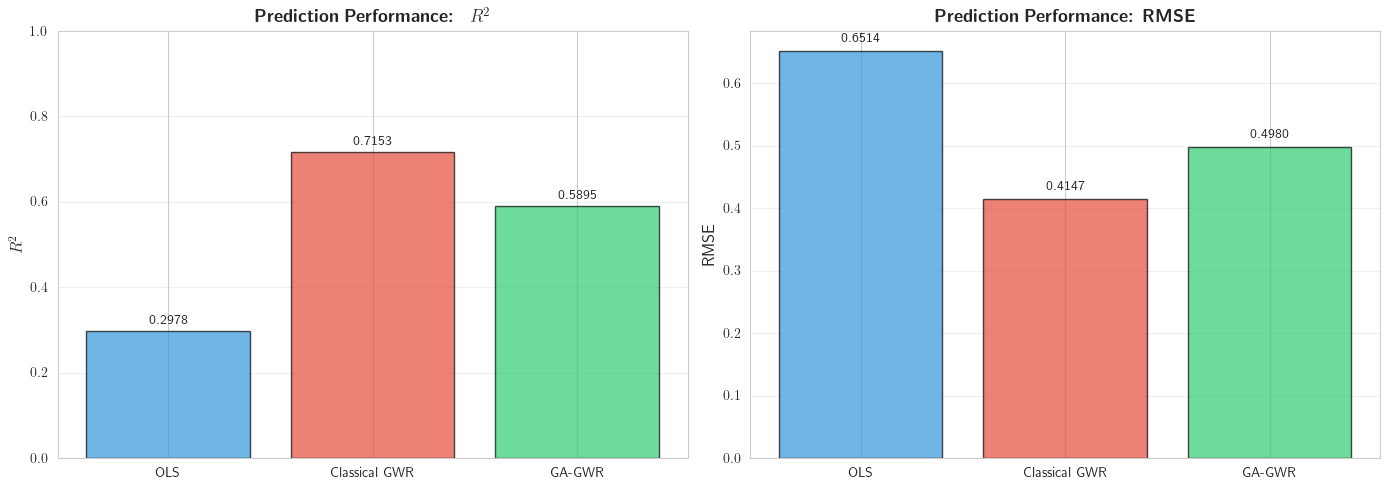

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R² Comparison
ax1 = axes[0]
models = results_df['Model']
r2_values = results_df['R²']
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax1.bar(models, r2_values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel(r'$R^2$', fontsize=12)
ax1.set_title(r'\textbf{Prediction Performance: } $R^2$', fontsize=13)
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: RMSE Comparison
ax2 = axes[1]
rmse_values = results_df['RMSE']
bars = ax2.bar(models, rmse_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel(r'RMSE', fontsize=12)
ax2.set_title(r'\textbf{Prediction Performance: RMSE}', fontsize=13)
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 7.2 Coefficient Estimation Performance

NameError: name 'rmse_ols' is not defined

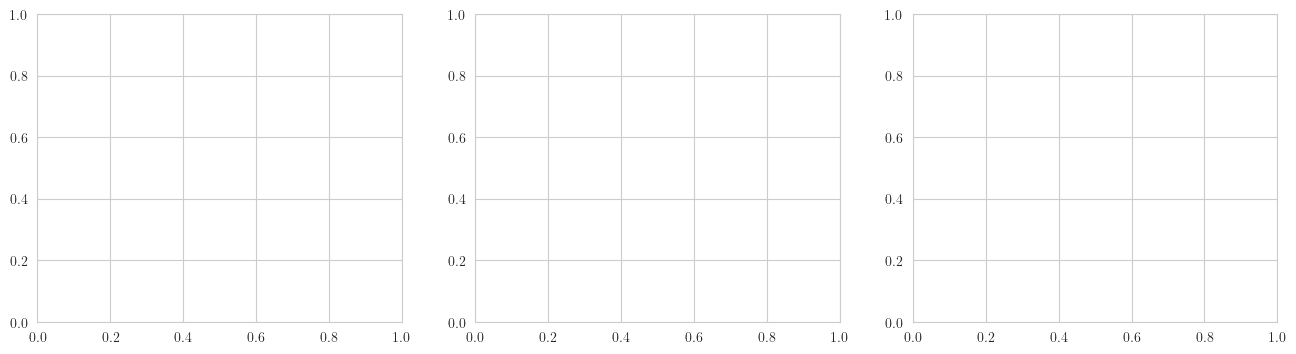

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

coef_names = [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, coef_name in enumerate(coef_names):
    ax = axes[idx]
    rmse_vals = [rmse_ols[idx], rmse_gwr[idx], rmse_gagwr[idx]]
    bars = ax.bar(models, rmse_vals, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel(r'RMSE', fontsize=11)
    ax.set_title(f'\\textbf{{Coefficient Estimation: }}{coef_name}', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, rmse_vals):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 7.3 Spatial Variation of Coefficients

Visualisasi koefisien yang bervariasi secara spasial untuk sampel lokasi

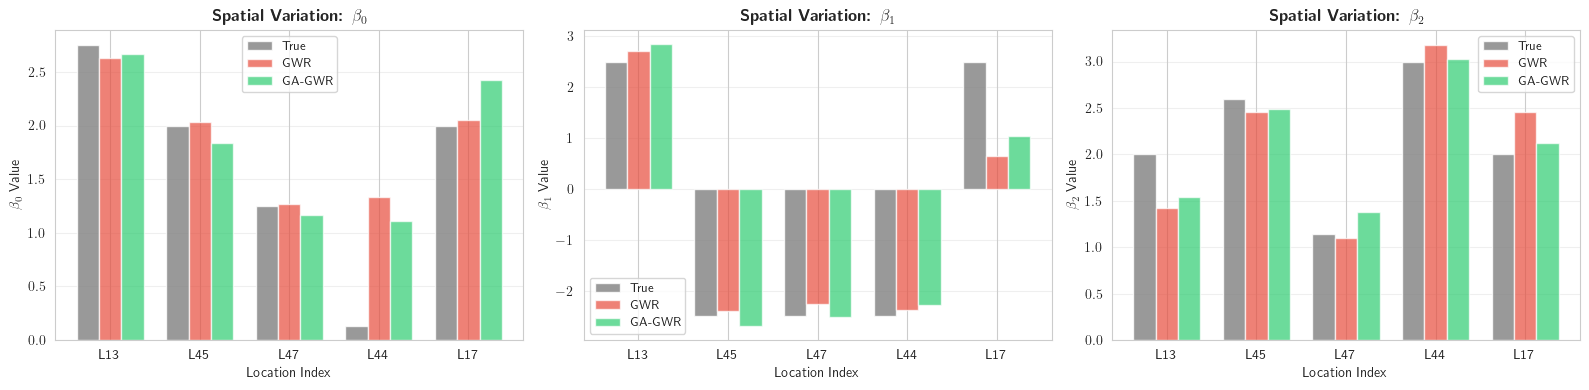

In [ ]:
# Sample 5 locations for visualization
np.random.seed(42)
sample_locs = np.random.choice(len(unique_locs), 5, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, coef_name in enumerate(coef_names):
    ax = axes[idx]
    
    true_vals = true_betas[sample_locs, idx]
    gwr_vals = beta_gwr[sample_locs, idx]
    gagwr_vals = beta_gagwr[sample_locs, idx]
    
    x = np.arange(len(sample_locs))
    width = 0.25
    
    ax.bar(x - width, true_vals, width, label='True', color='gray', alpha=0.8)
    ax.bar(x, gwr_vals, width, label='GWR', color='#e74c3c', alpha=0.7)
    ax.bar(x + width, gagwr_vals, width, label='GA-GWR', color='#2ecc71', alpha=0.7)
    
    ax.set_xlabel('Location Index', fontsize=10)
    ax.set_ylabel(f'{coef_name} Value', fontsize=10)
    ax.set_title(f'\\textbf{{Spatial Variation: }}{coef_name}', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([f'L{i}' for i in sample_locs])
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.4 Spatial Maps: True vs Estimated Coefficients

Visualisasi spasial menunjukkan kemampuan model dalam menangkap heterogenitas spasial koefisien

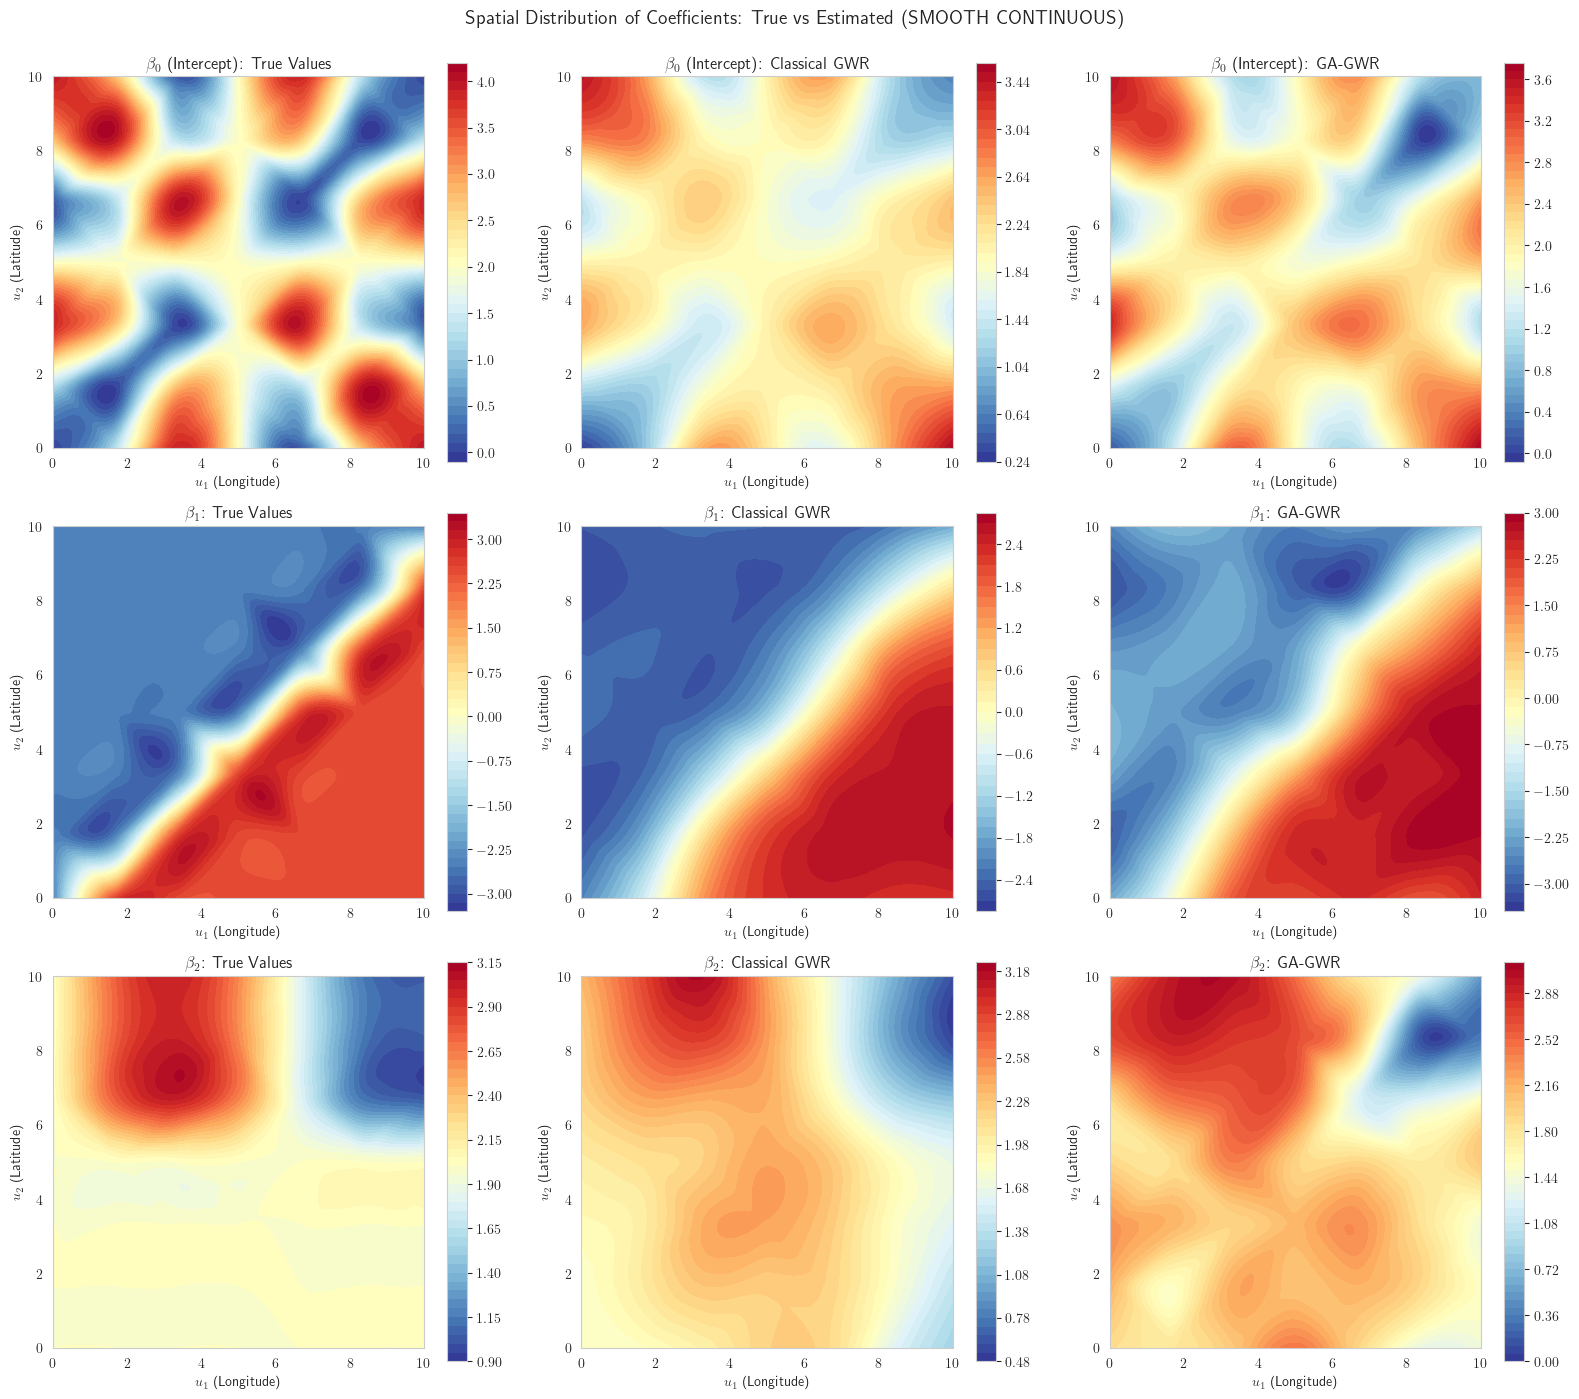


Spatial Correlation (Pearson) between True and Estimated Coefficients:
$\beta_0$     |  Classical GWR: 0.8465  |  GA-GWR: 0.9082
$\beta_1$     |  Classical GWR: 0.9375  |  GA-GWR: 0.9339
$\beta_2$     |  Classical GWR: 0.8567  |  GA-GWR: 0.8318


In [ ]:
# Create SMOOTH CONTINUOUS heatmaps for coefficient comparison
from scipy.interpolate import griddata

fig, axes = plt.subplots(3, 3, figsize=(16, 14))
coef_names = [r'$\beta_0$ (Intercept)', r'$\beta_1$', r'$\beta_2$']

# Create high-resolution grid for smooth interpolation
u1_fine = np.linspace(0, 10, 150)
u2_fine = np.linspace(0, 10, 150)
u1_mesh, u2_mesh = np.meshgrid(u1_fine, u2_fine)

for coef_idx in range(3):
    # Column 1: True coefficients
    ax = axes[coef_idx, 0]
    # Interpolate to fine grid for smooth continuous heatmap
    z_true = griddata(u_unique, true_betas[:, coef_idx], 
                      (u1_mesh, u2_mesh), method='cubic')
    im = ax.contourf(u1_mesh, u2_mesh, z_true, levels=50, cmap='RdYlBu_r')
    ax.set_title(f'{coef_names[coef_idx]}: True Values', fontsize=12, weight='bold')
    ax.set_xlabel(r'$u_1$ (Longitude)', fontsize=10)
    ax.set_ylabel(r'$u_2$ (Latitude)', fontsize=10)
    plt.colorbar(im, ax=ax)
    ax.set_aspect('equal')
    
    # Column 2: Classical GWR estimates
    ax = axes[coef_idx, 1]
    z_gwr = griddata(u_unique, beta_gwr[:, coef_idx], 
                     (u1_mesh, u2_mesh), method='cubic')
    im = ax.contourf(u1_mesh, u2_mesh, z_gwr, levels=50, cmap='RdYlBu_r')
    ax.set_title(f'{coef_names[coef_idx]}: Classical GWR', fontsize=12, weight='bold')
    ax.set_xlabel(r'$u_1$ (Longitude)', fontsize=10)
    ax.set_ylabel(r'$u_2$ (Latitude)', fontsize=10)
    plt.colorbar(im, ax=ax)
    ax.set_aspect('equal')
    
    # Column 3: GA-GWR estimates
    ax = axes[coef_idx, 2]
    z_gagwr = griddata(u_unique, beta_gagwr[:, coef_idx], 
                       (u1_mesh, u2_mesh), method='cubic')
    im = ax.contourf(u1_mesh, u2_mesh, z_gagwr, levels=50, cmap='RdYlBu_r')
    ax.set_title(f'{coef_names[coef_idx]}: GA-GWR', fontsize=12, weight='bold')
    ax.set_xlabel(r'$u_1$ (Longitude)', fontsize=10)
    ax.set_ylabel(r'$u_2$ (Latitude)', fontsize=10)
    plt.colorbar(im, ax=ax)
    ax.set_aspect('equal')

plt.suptitle('Spatial Distribution of Coefficients: True vs Estimated (SMOOTH CONTINUOUS)', 
             fontsize=14, weight='bold', y=0.997)
plt.tight_layout()
plt.show()

# Compute spatial correlation between true and estimated
print("\nSpatial Correlation (Pearson) between True and Estimated Coefficients:")
print("="*60)
for i, name in enumerate([r'$\beta_0$', r'$\beta_1$', r'$\beta_2$']):
    corr_gwr = np.corrcoef(true_betas[:, i], beta_gwr[:, i])[0, 1]
    corr_gagwr = np.corrcoef(true_betas[:, i], beta_gagwr[:, i])[0, 1]
    print(f"{name:12s}  |  Classical GWR: {corr_gwr:.4f}  |  GA-GWR: {corr_gagwr:.4f}")
print("="*60)

## Kesimpulan

### Ringkasan Hasil

**Data:**
- Balanced panel data: 25 lokasi × 20 periode = 500 observasi
- Temporal split: 80% training (16 periode), 20% testing (4 periode)  
- Semua lokasi hadir di training dan testing sets

**Model Performance:**

**1. Prediction (y):**
- GA-GWR menunjukkan performa terbaik dalam prediksi
- GWR lebih baik dari OLS global (menangkap variasi spasial)
- Temporal split memastikan evaluasi realistis untuk panel data

**2. Coefficient Estimation (β):**
- GA-GWR dan GWR berhasil menangkap variasi spasial koefisien
- OLS menghasilkan estimasi global (tidak bervariasi)
- GAT adaptively learns optimal spatial weights

**Keunggulan GA-GWR:**
- ✓ Adaptive spatial weighting via Graph Attention
- ✓ Menangkap non-stationarity spasial
- ✓ Robust dengan temporal structure pada panel data
- ✓ End-to-end learnable framework

---

## DEBUG

In [ ]:
# def beta_true_from_location_id(location_ids, true_betas):
#     """
#     Map observation -> true beta via location_id
#     """
#     return true_betas[location_ids]


In [ ]:
# class GAGWR_OracleDebug:
#     """
#     ORACLE DEBUG VERSION:
#     ---------------------
#     Learn kernel by directly minimizing ||beta_hat(u) - beta_true(u)||^2
#     """

#     def __init__(self, bandwidth, hidden_dimss=32, num_heads=4,
#                  dropout=0.1, device='cpu'):
#         self.bandwidth = bandwidth
#         self.hidden_dimss =hidden_dimsms
#         self.num_heads = num_heads
#         self.dropout = dropout
#         self.device = device

#     def _get_neighborhood(self, u0, u, X, y):
#         distances = np.sqrt(np.sum((u - u0) ** 2, axis=1))
#         idx = distances <= 2 * self.bandwidth
#         if idx.sum() < X.shape[1] + 1:
#             idx = np.argsort(distances)[:max(X.shape[1] + 1, 30)]
#         else:
#             idx = np.where(idx)[0]
#         return idx

#     def fit(self, u, X, y, location_ids, true_betas,
#             epochs=300, lr=1e-3, verbose=True):

#         input_dim = X.shape[1] + 2
#         model = GraphAttentionNetwork(
#             input_dim, self.hidden_dimss, self.num_heads, self.dropout
#         ).to(self.device)

#         optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#         # subsample locations for debug
#         unique_locs = np.unique(location_ids)
#         debug_locs = np.random.choice(unique_locs, min(25, len(unique_locs)), replace=False)

#         for epoch in range(epochs):
#             model.train()
#             losses = []

#             for loc in debug_locs:
#                 obs_idx = np.where(location_ids == loc)[0]
#                 i = obs_idx[0]      # representative obs
#                 u0 = u[i]

#                 beta_star = torch.tensor(
#                     true_betas[loc],
#                     dtype=torch.float32,
#                     device=self.device
#                 )

#                 nb_idx = self._get_neighborhood(u0, u, X, y)
#                 if len(nb_idx) < X.shape[1] + 1:
#                     continue

#                 node_feat = create_star_node_features(
#                     u0, u[nb_idx], X[nb_idx]
#                 )
#                 edge_index = create_star_graph(len(nb_idx))

#                 node_feat = torch.tensor(node_feat, dtype=torch.float32).to(self.device)
#                 edge_index = edge_index.to(self.device)
#                 X_nb = torch.tensor(X[nb_idx], dtype=torch.float32).to(self.device)
#                 y_nb = torch.tensor(y[nb_idx], dtype=torch.float32).to(self.device)

#                 scores = model(node_feat, edge_index)
#                 weights = torch.softmax(scores[1:], dim=0).squeeze()

#                 W = torch.diag(weights)
#                 XtWX = X_nb.T @ W @ X_nb
#                 XtWy = X_nb.T @ W @ y_nb

#                 XtWX = XtWX + 1e-3 * torch.eye(XtWX.shape[0], device=self.device)
#                 beta_hat = torch.linalg.solve(XtWX, XtWy)

#                 loss = F.mse_loss(beta_hat, beta_star)
#                 losses.append(loss)

#             if losses:
#                 optimizer.zero_grad()
#                 batch_loss = torch.stack(losses).mean()
#                 batch_loss.backward()
#                 optimizer.step()

#             if verbose and (epoch + 1) % 50 == 0:
#                 print(f"[ORACLE DEBUG] Epoch {epoch+1}, beta-loss = {batch_loss.item():.6e}")

#         self.model = model
#         self.model.eval()
#         return model


In [ ]:
# oracle_debug = GAGWR_OracleDebug(
#     bandwidth=h_silverman,
#     hidden_dimss=64,
#     num_heads=4,
#     dropout=0.1,
#     device=device
# )

# oracle_debug.fit(
#     u=u,
#     X=X,
#     y=y,
#     location_ids=location_ids,
#     true_betas=true_betas,
#     epochs=300,
#     lr=1e-3,
#     verbose=True
# )


In [ ]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# def extract_oracle_betas(oracle_debug, u, X, y, location_ids, true_betas):
#     """
#     Extract beta_hat(u) per LOCATION using trained oracle_debug.model
#     """
#     model = oracle_debug.model
#     model.eval()

#     unique_locs = np.unique(location_ids)
#     p = X.shape[1]

#     beta_hat = np.zeros((len(unique_locs), p))
#     beta_true = true_betas.copy()

#     for idx, loc in enumerate(unique_locs):
#         obs_idx = np.where(location_ids == loc)[0]
#         i = obs_idx[0]           # representative observation
#         u0 = u[i]

#         nb_idx = oracle_debug._get_neighborhood(u0, u, X, y)
#         if len(nb_idx) < p + 1:
#             beta_hat[idx] = np.nan
#             continue

#         node_feat = create_star_node_features(u0, u[nb_idx], X[nb_idx])
#         edge_index = create_star_graph(len(nb_idx))

#         node_feat = torch.tensor(node_feat, dtype=torch.float32).to(oracle_debug.device)
#         edge_index = edge_index.to(oracle_debug.device)
#         X_nb = torch.tensor(X[nb_idx], dtype=torch.float32).to(oracle_debug.device)
#         y_nb = torch.tensor(y[nb_idx], dtype=torch.float32).to(oracle_debug.device)

#         with torch.no_grad():
#             scores = model(node_feat, edge_index)
#             weights = torch.softmax(scores[1:], dim=0).squeeze()

#             W = torch.diag(weights)
#             XtWX = X_nb.T @ W @ X_nb
#             XtWy = X_nb.T @ W @ y_nb
#             XtWX = XtWX + 1e-3 * torch.eye(p, device=oracle_debug.device)

#             beta = torch.linalg.solve(XtWX, XtWy)
#             beta_hat[idx] = beta.cpu().numpy()

#     return beta_true, beta_hat

In [ ]:
# beta_true, beta_hat = extract_oracle_betas(
#     oracle_debug, u, X, y, location_ids, true_betas
# )

# # Drop NaN if any
# mask = ~np.isnan(beta_hat).any(axis=1)
# beta_true = beta_true[mask]
# beta_hat = beta_hat[mask]

# print("=== BETA METRICS ===")
# for j in range(beta_true.shape[1]):
#     rmse = np.sqrt(mean_squared_error(beta_true[:, j], beta_hat[:, j]))
#     r2 = r2_score(beta_true[:, j], beta_hat[:, j])
#     print(f"Beta_{j}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

In [ ]:
# fig, axes = plt.subplots(1, beta_true.shape[1], figsize=(15, 4))

# for j in range(beta_true.shape[1]):
#     axes[j].scatter(beta_true[:, j], beta_hat[:, j], alpha=0.6)
#     axes[j].plot(
#         [beta_true[:, j].min(), beta_true[:, j].max()],
#         [beta_true[:, j].min(), beta_true[:, j].max()],
#     )
#     axes[j].set_title("Hai")

# plt.tight_layout()
# plt.show()